# [Computational Social Science] 
## 3-2 Tree-Based Methods and Ensemble Methods - Solutions

In this lab, we will explore decision trees and their extensions. We will also introduce ensemble machine learning, which involves combining several machine learning algorithms together to create a better model.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This prevents the potential of crashing your root Python/Anaconda installation. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. If you have already created a virtual enviornment, you can run the following command to activate it. <br>
`conda activate <virtual_env_name>`
For example, if your virtual environment was named as legal-studies, run the following command. <br>
`conda activate legal-studies`
To deactivate your virtual environment after you are done working with the lab, run the following command. <br>
`conda deactivate`

## Data

We're going to use our Census Income dataset dataset again for this lab. Load the dataset in.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

%matplotlib inline
#sns.set_style("darkgrid")

In [2]:
# Create a list of column names, found in "adult.names"
col_names = ['age', 'workclass', 'fnlwgt',
            'education', 'education-num',
            'marital-status', 'occupation', 
             'relationship', 'race', 
             'sex', 'capital-gain',
            'capital-loss', 'hours-per-week',
            'native-country', 'income-bracket']

# Read table from the data folder
census = pd.read_table("../../data/adult.data", sep = ',', names = col_names)
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Remember, we need to preprocess the data to binarize the target and dummify our categorical features.

In [3]:
# Target
lb_style = LabelBinarizer()
y = census['income-bracket-binary'] = lb_style.fit_transform(census["income-bracket"])

# Features
X = census.drop(['income-bracket', 'fnlwgt', 'income-bracket-binary'], axis = 1)
X = pd.get_dummies(X)
X.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13,2174,0,40,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,13,0,0,13,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,9,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
3,53,7,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,28,13,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


## Decision Tree Classifier

The first model we will look at is the decision tree. Using the [`tree.DecisionTreeClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) method, let's implement a cross-validation approach to predicting income. We will initialize the model with the standard configurations from the Classification lab.

In [4]:
# Initialize a Decision Tree Classifier
dt_classifier = tree.DecisionTreeClassifier(criterion='gini',  # or 'entropy' for information gain
                       splitter='best',  # or 'random' for random best split
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,  # number of features to look for when splitting
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07, #early stopping
                       random_state = 10) #random seed

In [5]:
# cross_val_score returns the accuracy score by default but you can change this with the "scoring" argument
scores = cross_val_score(dt_classifier, X, y, cv=5)

In [6]:
scores

array([0.82266237, 0.82079238, 0.81511057, 0.8240172 , 0.82079238])

In [7]:
# Take the mean score from the results of cross validation
scores.mean()

0.8206749796570156

.82 accuracy, not bad! We can also visualize the decision tree to see how it made its splits. Note we limit the max depth to 4 so that the code runs quickly, but in practice you might want to visualize the entire tree.

In [8]:
len(X)

32561

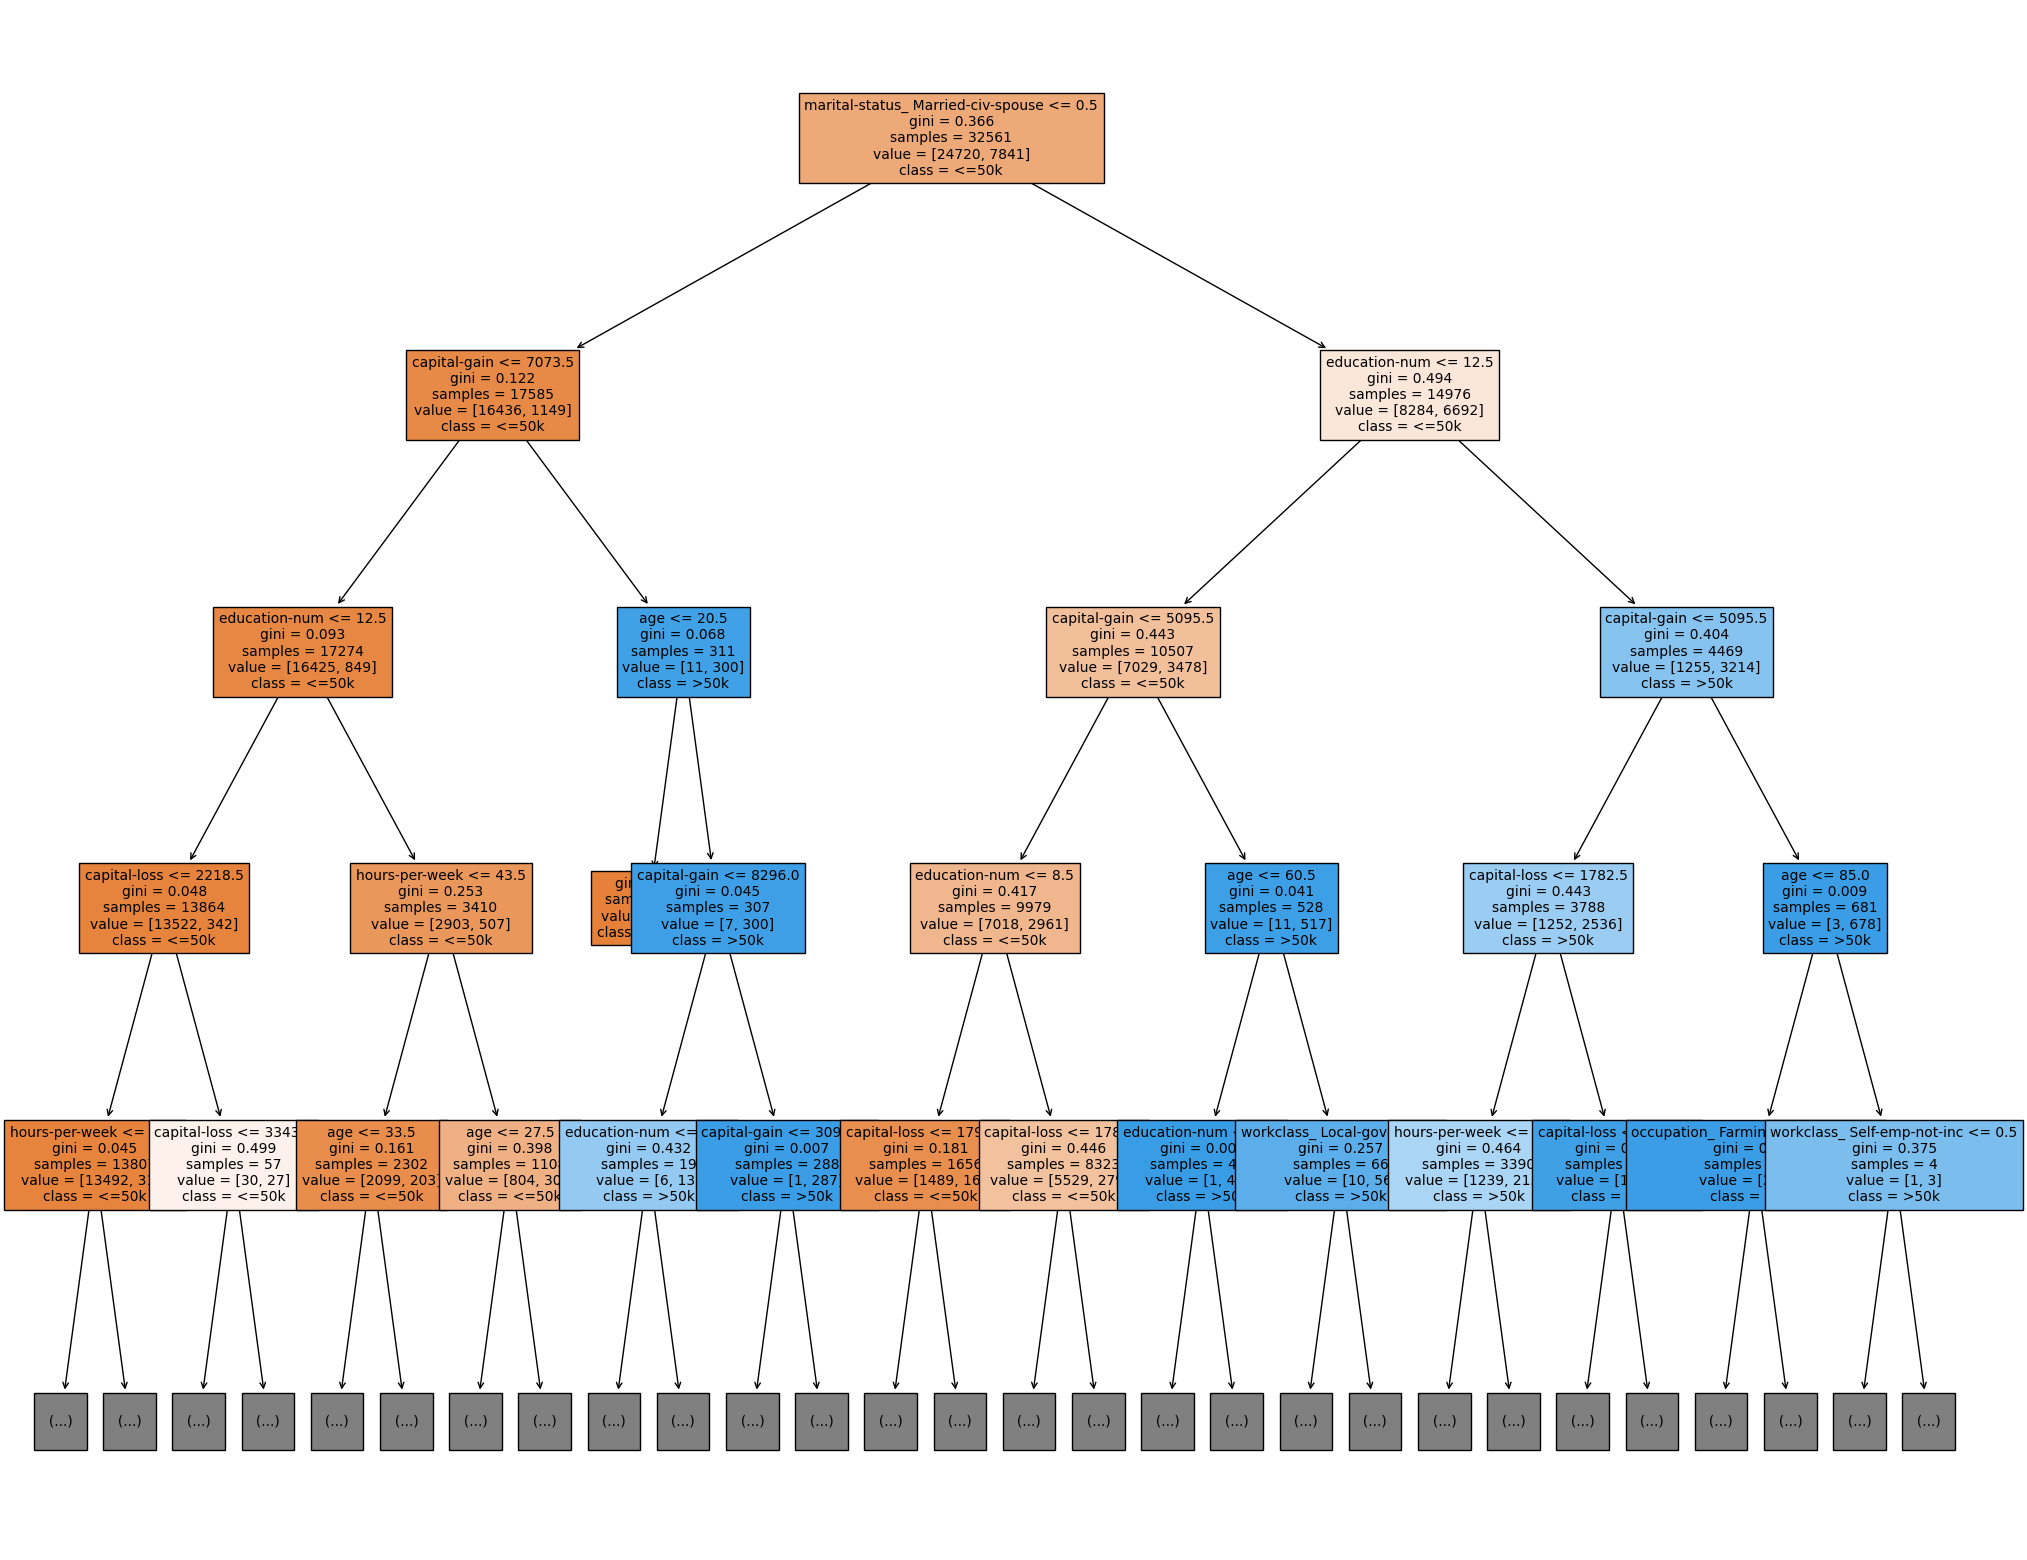

In [9]:
dt_classifier.fit(X, y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_classifier, 
                   feature_names=X.columns,  
                   class_names=["<=50k", ">50k"],
                   filled=True,
                  fontsize = 10,
                  max_depth = 4)

In [10]:
# We can use the .max_depth attribute to check out the depth of our entire tree
dt_classifier.tree_.max_depth

52

In [11]:
# Remind ourselves how many samples in our negative class
np.count_nonzero(y==0)

24720

In [12]:
# Check the samples after root node
X['marital-status_ Married-civ-spouse'].value_counts()

marital-status_ Married-civ-spouse
False    17585
True     14976
Name: count, dtype: int64

In [13]:
# Getting the most informative features
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(dt_classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
32,marital-status_ Married-civ-spouse,0.214
0,age,0.161
1,education-num,0.123
2,capital-gain,0.119
4,hours-per-week,0.101
...,...,...
77,native-country_ Greece,0.000
78,native-country_ Guatemala,0.000
79,native-country_ Haiti,0.000
80,native-country_ Holand-Netherlands,0.000


# Ensemble Learning
Ensemble learning is a machine learning paradigm where multiple learners (also known as base or individual models) are trained to solve the same problem. The main idea behind ensemble learning is that a group of "weak learners" can come together to form a "strong learner". Each weak learner makes a prediction, and then the ensemble model makes its final prediction based on the votes or the outputs of all the weak learners.

Ensemble learning often significantly improves machine learning results by combining several models. This approach allows the production of better predictive performance compared to a single model.

## Random Forest

Next, we'll take a look at the [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Random Forest is an extension of the decision tree method. Rather than construct just one tree, a random forest grows many trees, using a subset of features to grow each tree. The trees then make predictions, and the random forest takes a majority vote from the trees to determine the winner. Random forest is known as a ["bagging"](https://en.wikipedia.org/wiki/Bootstrap_aggregating) method. Fill in the code below to train a random forest using cross-validation.

In [7]:
# Initialize a random forest
rf_classifier = RandomForestClassifier(criterion='gini',  # or 'entropy' for information gain
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,  # number of features to look for when splitting
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07, #early stopping
                       random_state = 10) #random seed

In [8]:
# Some algorithms will expect you to ravel the target
scores = cross_val_score(rf_classifier, X, y.ravel(), cv=5)

KeyboardInterrupt: 

In [ ]:
scores.mean()

Although it is difficult to visualize a forest of trees, we *can* still visualize the feature importances. Use the code below to look at the top 10 most important features. What do you notice? Do you think we actually need a large feature space?

In [ ]:
# Refit the random forest on the whole dataset to get feature importances
rf_classifier.fit(X, y.ravel())
import seaborn as sns

feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(rf_classifier.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]
sns.barplot(x = "Importance", y = "Feature", data = feat_importances.nlargest(10, 'Importance'))
plt.show()

We see that only a handful of features are contributing a lot to the model. We could probably simplify the decisionmaking considerably. Try training a new decision tree with max depth 5 and only use the 10 most important features.

In [ ]:
dt_reduced_classifier = tree.DecisionTreeClassifier(criterion='gini',  # or 'entropy' for information gain
                       splitter='best',  # or 'random' for random best split
                       max_depth=5,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,  # number of features to look for when splitting
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07, #early stopping
                       random_state = 10) #random seed

important_features = feat_importances.nlargest(10, 'Importance')['Feature']

X_reduced = X[X.columns[X.columns.isin(important_features)]]

dt_reduced_classifier.fit(X_reduced, y)
fig = plt.figure(figsize=(45,40))
_ = tree.plot_tree(dt_reduced_classifier, 
                   feature_names=X_reduced.columns,  
                   class_names=["<=50k", ">50k"],
                   filled=True,
                  fontsize = 10,
                  max_depth = 5)

In [ ]:
# Check the samples after root node
X['marital-status_ Married-civ-spouse'].value_counts()

Looks a lot more interpretable than a random forest! How did we do on accuracy?

In [ ]:
scores = cross_val_score(dt_reduced_classifier, X, y.ravel(), cv=5)
scores.mean()

Almost .85! Not quite as good as the whole random forest, but better than our original decision tree. Growing a random forest and then simplifying down to a more basic decision tree is the basic procedure recommended by the [select-regress-round](https://arxiv.org/pdf/1702.04690.pdf) framework.

**Question**: Why did a simplified decision tree get better accuracy than the first one we ran?

**Answer**: The original decision tree probably had very high variance and was too complex. A simplified tree that is pruned to a depth of 5 and only uses a few features likely generalizes better.

## Adaptive Boosting

The other approach for ensembling decision trees is called ["boosting"](https://en.wikipedia.org/wiki/Boosting_(machine_learning). Whereas random forests grow many decision trees in parallel and take a vote from them, boosting algorithms start with a strong classifier and iterate on it with weak learners. The weak learners are trained on the errors, which makes boosting algorithms well suited for making classifications in difficult cases. Try filling in the code below to train an [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).

In [ ]:
ada_classifier = AdaBoostClassifier(n_estimators=100)

In [ ]:
scores = cross_val_score(ada_classifier, X, y.ravel(), cv = 5)

In [ ]:
scores.mean()

# XGBoost


In [9]:
# !pip3 install xgboost
import xgboost as xgb

In [10]:
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=10)


# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# Perform cross-validation with 5-fold and return the trained estimators
cv_results = cross_validate(xgb_classifier, X, y.ravel(), cv=5, return_estimator=True, scoring=scoring)

# Print the results for accuracy, recall, precision, and F1 score
for metric in ['test_accuracy', 'test_recall', 'test_precision', 'test_f1']:
    scores = cv_results[metric]
    print(f"{metric[5:]}: {scores.mean():.3f}")



accuracy: 0.873
recall: 0.664
precision: 0.777
f1: 0.716


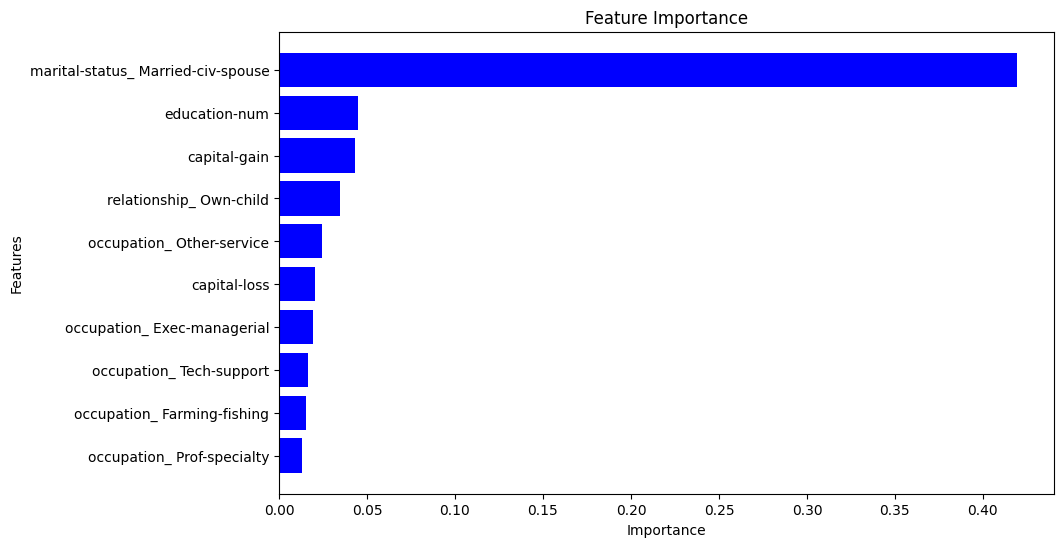

In [11]:
# Initialize an array to hold the feature importances
importances = np.zeros(X.shape[1])

# Average the feature importances over the folds
for estimator in cv_results['estimator']:
    importances += estimator.feature_importances_

importances /= 5  # Divide by the number of folds

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Take the top 10 features
feature_importance = feature_importance.head(10)

# Plot the feature importances
plt.figure(figsize=(10, 6))
# horizontal bar plot
plt.barh(feature_importance['feature'], feature_importance['importance'], color='b', align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis() # gca stands for "get current axis", which allows you to modify the properties of the axes.
# is a method that inverts the y-axis, meaning that the values that were at the bottom will now be at the top, and vice versa.
plt.show()


## Ensemble Learning Beyond Trees

You can also create ensembles with algorithms beyond decision trees. Scikit's ensemble module contains several different options for training ensemble models. Here, we will focus on the [`VotingClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) method. A voting classifier works in a similar fashion to random forest. However, instead of taking a majority vote of decision trees, it takes a majority vote of various algorithms. The voting can be "hard" which means the ensemble uses a majority vote of predicted classes, or "soft" meaning the votes are weighted by the probability associated with the prediction. Run the code below to initialize a logistic regression, a random forest, and an adaboost model. Pass all three of these into the VotingClassifier to train an ensemble model, and check out their accuracy scores.

In [ ]:
# Logistic Regression - using liblinear solver
log_reg = LogisticRegression(random_state = 10, solver='liblinear')

# Random Forest
rf_classifier = RandomForestClassifier(criterion='gini',  # or 'entropy' for information gain
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,  # number of features to look for when splitting
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07, #early stopping
                       random_state = 10) #random seed

# AdaBoost
ada_classifier = AdaBoostClassifier(n_estimators=100)

voting_classifier = VotingClassifier(
                        estimators = [('lr', log_reg),
                                     ('rf', rf_classifier),
                                     ('ada', ada_classifier)],
                        voting = 'hard')

# Loop through each model to report Accuracy
for clf, label in zip([log_reg, 
                       rf_classifier, 
                       ada_classifier, 
                       voting_classifier], ['Logistic Regression', 
                                            'Random Forest', 
                                            'Ada Boost',
                                            'Ensemble']):
         scores = cross_val_score(clf, X, y.ravel(), scoring='accuracy', cv=5)
         print('Accuracy: %0.2f [%s]' % (scores.mean(), label))

How did the ensemble do? Next, try to use a soft voting classifier to get the predicted probabilities for each prediction. Try using the `predict_proba()` method to get the predicted probabilities.

In [ ]:
voting_classifier = VotingClassifier(
                        estimators = [('lr', log_reg),
                                     ('rf', rf_classifier),
                                     ('ada', ada_classifier)],
                        voting = 'soft')

probas = [c.fit(X, y.ravel()).predict_proba(X)[:,1] for c in (log_reg, rf_classifier, ada_classifier, voting_classifier)]

Let's put our predicted probabilities into a dataframe so we can visualize them.

In [ ]:
probs_df = pd.DataFrame.from_records(probas).T
probs_df.rename(columns = {0: 'logit',
                          1: 'rf',
                          2: 'ada',
                          3: 'ensemble'}, inplace = True)
probs_df.head()

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.histplot(probs_df, x = "logit", ax = ax)
ax = fig.add_subplot(2, 2, 2)
sns.histplot(probs_df, x = "rf", ax = ax)
ax = fig.add_subplot(2, 2, 3)
sns.histplot(probs_df, x = "ada", ax = ax)
ax = fig.add_subplot(2, 2, 4)
sns.histplot(probs_df, x = "ensemble", ax = ax)
plt.show()

**Question**: Do you notice something about the distribution of the predicted probabilities? Can you explain the output of `AdaboostClassifier`?

**Answer**: The logistic regression and random forest models are somewhat bimodal, but both skew heavily right. The AdaBoost model on the other hand is centered around .47 or so. These distributions make sense because AdaBoost iteratively trains on edge cases, meaning the ones where it could be on other side of .5. The ensemble blends these various models together.

---
Authored by Aniket Kesari. Minor edits by Tom van Nuenen 2022.